TODO:

- [ ] implement ring-all-reduce (and check it works)
- [ ] 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np

import itertools
from time import sleep, time
import toolz
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def get_model(model=None):
    if model is None:
        return Net()
    return getattr(torchvision.models, model)()

resnet_models = [m for m in dir(torchvision.models)
                 if 'resnet' in m and m != 'resnet']
models = [get_model(model=model) for model in resnet_models]

In [3]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
from distributed import Client
import distributed as d
client = Client()
client

Client Scheduler: tcp://127.0.0.1:62559 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [5]:
# num_workers = 4
# model = get_model()
model = Net()
iters = 20

## Decentralized implementation

In [6]:
def compute_grad(model, data, target, optimizer, args, device):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # optimizer.step()  # do not include this
    return {k: p.grad for k, p in model.named_parameters()}

In [7]:
import toolz
from pprint import pprint
from time import time
import numpy as np

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from ps import Worker

In [10]:
def train_decentralized(model, args, num_workers=4, iters=20):
    params = [np.prod(tuple(p.size())) for p in model.parameters()]
    futures = [client.submit(Worker, model, args,
                             compute_grad=compute_grad,
                             worker_id=i, num_workers=num_workers,
                             actor=True)
               for i in range(num_workers)]
    workers = client.gather(futures)
    
    times = {'compute_grad': 0, 'comm_grad': 0}
    train_start = time()
    grad_start = time()
    for k in range(iters):
        # compute gradient
        futures = [worker.compute_gradients() for worker in workers]
        finished = [f.result() for f in futures]
        assert all(finished)
        times['compute_grad'] += time() - grad_start

        # communication scheme (should be all-reduce)
        start = time()
        futures = []
        for i, w1 in enumerate(workers):
            for j, w2 in enumerate(workers):
                futures += [w1.send(w2)]
        finished = [f.result() for f in futures]
        assert all(finished)
        times['comm_grad'] += time() - start

        # apply the gradients
        grad_start = time()
        futures = [worker.apply_gradients() for worker in workers]
        
    meta = {'compute_grad': times['compute_grad'] / iters,
            'comm_grad': times['comm_grad'] / iters,
            'params': sum(params),
            'avg_step_time': (time() - train_start) / iters,
            'iters': iters,
            'num_workers': num_workers}
    
    models = [w._model for w in workers]
    params = [dict(model.named_parameters())
              for model in models]
    check = toolz.first(params)
    for model in models:
        for name, p in model.named_parameters():
            diff = torch.norm(p - check[name])
            diff /= torch.norm(check[name])
            # TODO: reduce the relative error constraint
            # Most values are close to 1e-8, a couple aren't
            assert diff.item() < 40e-3
    return meta

In [11]:
all_meta = []
# meta = [test_decentralized(model, 4, iters)]
meta = [train_decentralized(model, args, num_workers=num_workers, iters=20)
        for num_workers in [1, 2, 4, 8]]

In [12]:
all_meta += [{'arch': 'decentralized', **m} for m in meta]

# Centralized implementation

In [6]:
from time import sleep

In [7]:
def train(model, device, data, target):
    model.train()
    
    data, target = data.to(device), target.to(device)
    # optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # optimizer.step()
    return model

In [8]:
%load_ext autoreload
%autoreload 2

In [11]:
from ps import PS

In [46]:
def worker(ps, device, train_loader,
           worker_id=0, num_workers=1,
           iters=10):
    times = {'comm_grad': 0, 'compute_grad': 0, 'comm_model': 0}
    
    step_start, _model = ps.pull_latest().result()
    
    whole_start = time()
    params = [np.prod(tuple(p.size())) for p in _model.parameters()]
    
    for step in range(step_start, step_start + iters):
        start = time()
        while _model is None:
            _model = ps.pull(key=step).result()
            sleep(1e-3)
        times['comm_model'] += time() - start
        model, _model = _model, None
        #  param_check = toolz.last(model.parameters())
        #  check = param_check.detach().numpy().flat[:4]
        #  print("worker {} iter {}, last params = {}".format(worker_id, iters, check))
            
        data, target = next(iter(train_loader))
        start = time()
        model = train(model, device, data, target)
        grads = {name: p.grad.data for name, p in model.named_parameters()}
        times['compute_grad'] += time() - start
        
        start = time()
        ps.push(step, grads)
        times['comm_grad'] += time() - start
        
    meta = {'compute_grad': times['compute_grad'] / iters,
            'comm_model': times['comm_model'] / iters,
            'comm_grad': times['comm_grad'] / iters,
            'avg_step_time': (time() - whole_start) / iters,
            'iters': iters,
            'num_workers': num_workers,
            'params': sum(params)}
    return meta

In [47]:
def train_centralized(client, model, args, num_workers, iters, batch_size=64):
    batch_size //= num_workers
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, model = client.scatter([train_loader, model])

    ps = client.gather(client.submit(PS, model, args, device,
                                     num_workers=num_workers,
                                     actor=True))
    futures = [client.submit(worker, ps, device, train_loader,
                             iters=iters,
                             worker_id=i, num_workers=num_workers)
               for i in range(num_workers)]
    meta = client.gather(futures)
    meta = [{'batch_size': batch_size, **m} for m in meta]
    return meta

In [48]:
meta = [train_centralized(client, model, args, num_workers, iters)
        for num_workers in [1, 2, 4, 8]]

In [49]:
meta = [{'arch': 'centralized', **mi} for m in meta for mi in m]

In [50]:
all_meta = []

In [51]:
all_meta += meta

In [52]:
import pandas as pd
df = pd.DataFrame(all_meta)
df.head()

,arch,avg_step_time,batch_size,comm_grad,comm_model,compute_grad,iters,num_workers,params
0,centralized,0.046323,64,0.000248,0.013148,0.021299,20,1,21840
1,centralized,0.062312,32,0.000220,0.032333,0.021727,20,2,21840
2,centralized,0.054865,32,0.000136,0.026807,0.018875,20,2,21840
3,centralized,0.090782,16,0.000133,0.063995,0.017684,20,4,21840
4,centralized,0.085167,16,0.000213,0.064671,0.013914,20,4,21840


Here's calling the train function. This can be called repeated times, since the function `worker` gets the latest model to start.

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

keep = df.drop(columns=['params', 'batch_size', 'iters', 'avg_step_time'])
melted = keep.melt(id_vars=['arch', 'num_workers'], value_name='time (s)')
melted.head()

,arch,num_workers,variable,time (s)
0,centralized,1,comm_grad,0.000248
1,centralized,2,comm_grad,0.000220
2,centralized,2,comm_grad,0.000136
3,centralized,4,comm_grad,0.000133
4,centralized,4,comm_grad,0.000213


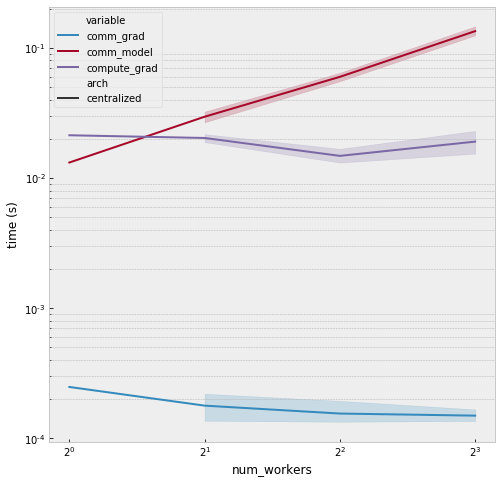

In [54]:
w = 8
fig, ax = plt.subplots(figsize=(w, w))
sns.lineplot(x='num_workers', y='time (s)',
             hue='variable', style='arch', data=melted)
ax.set_yscale("log")
ax.set_xscale("log", basex=2)
ax.grid(which='both')
plt.savefig('centralized.png', dpi=300)